In [1]:
import librosa
import librosa.display
import numpy as np
import os
import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline
mpl.rcParams['figure.dpi']= 100
from skimage.transform import resize
import torchaudio.transforms as T
import torch
import json

nfft = 2048
win_length = 2048 # int(16000 * 0.025)
n_mels = 64
hop_length = 16 # int(16000 * 0.01)
fmin, fmax = 50, 350
melspectrogram = T.MelSpectrogram(
    sample_rate=16000, win_length=win_length, n_mels=n_mels, n_fft=nfft, hop_length=hop_length, f_min=fmin, f_max=fmax,
)

/home/tjy/anaconda3/lib/python3.7/site-packages/torchaudio/backend/utils.py:54: UserWarning: "sox" backend is being deprecated. The default backend will be changed to "sox_io" backend in 0.8.0 and "sox" backend will be removed in 0.9.0. Please migrate to "sox_io" backend. Please refer to https://github.com/pytorch/audio/issues/903 for the detail.
  '"sox" backend is being deprecated. '


In [2]:
def spectro(y: np.ndarray, start: float, dur: float, sr=16000):
    S = librosa.feature.melspectrogram(
        y=y, sr=sr, n_mels=64, n_fft=nfft, hop_length=hop_length, fmin=fmin, fmax=fmax
    )
    S = librosa.power_to_db(S)

    # crop to the start and the end of a phone
    end = start + dur
    s, e = librosa.time_to_frames([start, end], sr=sr, hop_length=hop_length)
    s = np.max(s, 0)
    e = np.max(e, 0)

    return S[:, s:e + 1]


def spectro1(y, start: float, dur: float, sr=16000, fmin=50, fmax=350, hop_length=16, nfft=2048):
    y = torch.as_tensor(y, dtype=torch.float32)
    S = melspectrogram(y)
    S = 10 * torch.log10(S)

    # crop to the start and the end of a phone
    end = start + dur
    s, e = librosa.time_to_frames([start, end], sr=sr, hop_length=hop_length)
    s = np.max(s, 0)
    e = np.max(e, 0)

    return S[:, s:e + 1].numpy()


def postprocess(S):
    S = S[::-1, :]
    S = resize(
        S, output_shape=(225, 225),
        anti_aliasing=False, preserve_range=True, clip=False,
        mode='constant', cval=0, order=0,
    )
    return S

# Mel-Spectrogram

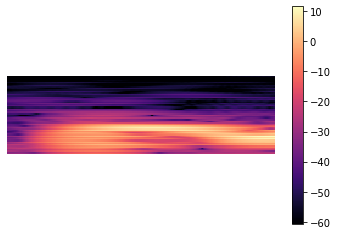

In [3]:
start, dur = 0.53, 0.24
# start, dur = 0.1, 0.1

y, _ = librosa.load('tmp/IC0001W0010_sp11.wav', sr=16000)
S = spectro(y, start/1.1, dur/1.1)
# S = postprocess(S)
plt.imshow(S, cmap='magma')
plt.axis('off')
plt.colorbar()

(-0.5, 224.5, 224.5, -0.5)

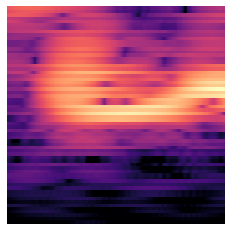

In [4]:
y, _ = librosa.load('tmp/IC0001W0010_sp09.wav', sr=16000)
S = spectro(y, start/0.9, dur/0.9)
S = postprocess(S)
plt.imshow(S, cmap='magma')
plt.axis('off')

# Visualize alignment

In [5]:
utt2tones = json.load(open('utt2tones.json'))

er4	| 0.540s to 0.690s
sh	| 0.585s to 0.810s
i2	| 0.690s to 0.915s
b	| 0.810s to 1.035s
a1	| 0.915s to 1.155s
g	| 1.035s to 1.260s
e4	| 1.155s to 1.380s
ch	| 1.260s to 1.515s
eng2	| 1.380s to 1.635s
sh	| 1.515s to 1.740s
i4	| 1.635s to 1.845s
d	| 1.740s to 1.950s
e5	| 1.845s to 2.070s
ch	| 1.950s to 2.205s
eng2	| 2.070s to 2.325s
j	| 2.205s to 2.445s
iao1	| 2.325s to 2.550s
l	| 2.445s to 2.655s
iang4	| 2.550s to 2.775s
ch	| 2.655s to 2.880s
u1	| 2.775s to 2.985s
x	| 2.880s to 3.090s
ian4	| 2.985s to 3.195s
l	| 3.090s to 3.285s
e5	| 3.195s to 3.390s
h	| 3.285s to 3.525s
uan2	| 3.390s to 3.645s
b	| 3.525s to 3.750s
i3	| 3.645s to 3.855s
z	| 3.750s to 3.975s
eng1	| 3.855s to 4.095s
zh	| 3.975s to 4.215s
ang3	| 4.095s to 4.350s
t	| 4.215s to 4.470s
ai4	| 4.350s to 4.590s
sh	| 4.470s to 4.755s
i4	| 4.590s to 4.860s


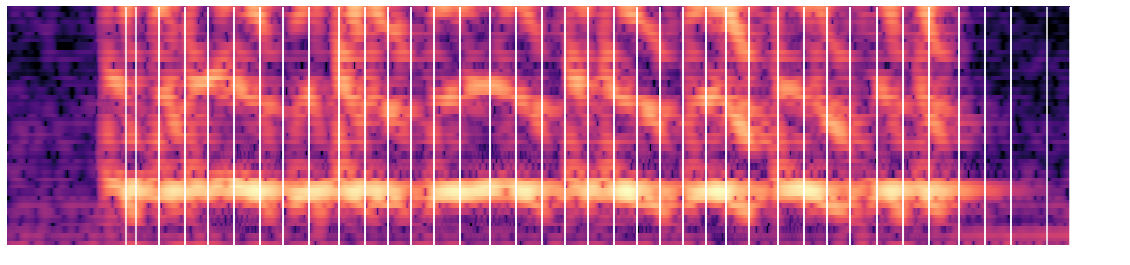

In [6]:
WAV_DIR = '/NASdata/AudioData/AISHELL-ASR-SSB/SPEECHDATA/'

def get_wav_path(utt: str):
    spk = utt[:7]
    return os.path.join(WAV_DIR, spk, f'{utt}.wav')

# utt = random.choice(list(utt2tones.keys()))
utt = 'SSB10070437'
data = utt2tones[utt]

timestamps = []
for tone, phone, start, dur in data:
    print(f'{phone}\t| {start:.3f}s to {start + dur:.3f}s')
    timestamps += [start, start + dur]
timestamps = np.asarray(timestamps)

min_sec = np.min(timestamps)
max_sec = np.max(timestamps)

fig_width = 1000
fig_height = 225

sr = 16000
# timestamps = librosa.time_to_frames(timestamps, sr=sr, hop_length=hop_length)
timestamps = fig_width * timestamps / max_sec

fig, ax = plt.subplots(figsize=(20, 5))

y, _ = librosa.load(get_wav_path(utt), sr=sr)
S = spectro(y, 0, 1000, sr=sr)
S = S[::-1, :]
S = resize(
    S, output_shape=(fig_height, fig_width),
    anti_aliasing=False, preserve_range=True, clip=False,
    mode='constant', cval=0, order=0,
)
plt.imshow(S, cmap='magma')
plt.axis('off')
ax.vlines(timestamps, 0, fig_height, colors='white')